In [1]:
import pandas as pd
import re
df = pd.read_csv("Bo_Nix_Throw_Log_2024.csv")
df['Description'] = df['Description'].astype(str)
features = ['Throw Depth', 'Pass Location', 'Formation', 'Complete Pass', 'Yards Gained', 'Receiver', 'Defense Team', 'Touchdown', 'Interception']
for col in features:
    df[col] = None
def parse_description(desc):
    text = desc.upper()
    result = {}
    if "SHORT" in text:
        result['Throw Depth'] = 'Short'
    elif "DEEP" in text:
        result['Throw Depth'] = 'Deep'
    elif "MEDIUM" in text:
        result['Throw Depth'] = 'Medium'
    else:
        result['Throw Depth'] = 'Unknown'
    if "LEFT" in text:
        result['Pass Location'] = 'Left'
    elif "MIDDLE" in text:
        result['Pass Location'] = 'Middle'
    elif "RIGHT" in text:
        result['Pass Location'] = 'Right'
    else:
        result['Pass Location'] = 'Unknown'
    if "SHOTGUN" in text:
        result['Formation'] = 'Shotgun'
    elif "UNDER CENTER" in text:
        result['Formation'] = 'Under Center'
    else:
        result['Formation'] = 'Other'
    if "INTERCEPTED" in text:
        result['Complete Pass'] = 0
        result['Interception'] = 1
    elif "INCOMPLETE" in text:
        result['Complete Pass'] = 0
        result['Interception'] = 0
    elif "PASS" in text:
        result['Complete Pass'] = 1
        result['Interception'] = 0
    else:
        result['Complete Pass'] = None
        result['Interception'] = 0
    yards = re.search(r"FOR (\d+) YARD", text)
    if yards:
        result['Yards Gained'] = int(yards.group(1))
    elif "NO GAIN" in text:
        result['Yards Gained'] = 0
    else:
        result['Yards Gained'] = None
    receiver = re.search(r"TO ([0-9]+-[A-Z\.\']+)", text)
    result['Receiver'] = receiver.group(1) if receiver else None
    defense_team = re.search(r"AT ([A-Z]{2,3}) ", text)
    result['Defense Team'] = defense_team.group(1) if defense_team else None
    result['Touchdown'] = 1 if "TOUCHDOWN" in text else 0
    return result
parsed = df['Description'].apply(parse_description).apply(pd.Series)
df = pd.concat([df, parsed], axis=1)
df.to_csv("Bo_Nix_Throw_Log_2024.csv", index=False, encoding='utf-8')

In [2]:
import pandas as pd

df = pd.read_csv("Bo_Nix_Throw_Log_2024.csv")

def get_completion_status(description):
    desc = str(description).upper()
    if "INCOMPLETE" in desc:
        return 0
    elif "PASS" in desc:
        return 1
    else:
        return None
df['Complete Pass'] = df['Description'].apply(get_completion_status)
df.to_csv("Bo_Nix_Throw_Log_2024.csv", index=False)
print("✅ Added completion labels to dataset!")
print("\n🎯 Completion Label Summary:")
print(df['Complete Pass'].value_counts(dropna=False))

✅ Added completion labels to dataset!

🎯 Completion Label Summary:
Complete Pass
1    413
0    207
Name: count, dtype: int64


In [3]:
import pandas as pd

df = pd.read_csv("Bo_Nix_Throw_Log_2024.csv")

print("Completion Summary:")
print(df['Complete Pass'].value_counts(dropna=False))

total = len(df)
complete = df['Complete Pass'].eq(1).sum()
incomplete = df['Complete Pass'].eq(0).sum()
missing = df['Complete Pass'].isna().sum()

print("Data Breakdown:")
print(f"Completions:   {complete} ({(complete/total)*100:.1f}%)")
print(f"Incompletions: {incomplete} ({(incomplete/total)*100:.1f}%)")
print(f"Missing:       {missing} ({(missing/total)*100:.1f}%)")

Completion Summary:
Complete Pass
1    413
0    207
Name: count, dtype: int64
Data Breakdown:
Completions:   413 (66.6%)
Incompletions: 207 (33.4%)
Missing:       0 (0.0%)


In [28]:
print(df.columns)

Index(['Description', 'Throw Depth', 'Pass Location', 'Complete Pass',
       'Formation', 'Yards Gained', 'Receiver', 'Defense Team', 'Touchdown',
       'Interception', 'Throw Depth.1', 'Pass Location.1', 'Formation.1',
       'Complete Pass.1', 'Interception.1', 'Yards Gained.1', 'Receiver.1',
       'Defense Team.1', 'Touchdown.1', 'Throw Depth.2', 'Pass Location.2',
       'Formation.2', 'Complete Pass.2', 'Interception.2', 'Yards Gained.2',
       'Receiver.2', 'Defense Team.2', 'Touchdown.2', 'Throw Depth.3',
       'Pass Location.3', 'Formation.3', 'Complete Pass.3', 'Interception.3',
       'Yards Gained.3', 'Receiver.3', 'Defense Team.3', 'Touchdown.3',
       'Throw Depth.4', 'Pass Location.4', 'Formation.4', 'Complete Pass.4',
       'Interception.4', 'Yards Gained.4', 'Receiver.4', 'Defense Team.4',
       'Touchdown.4', 'Throw Depth.5', 'Pass Location.5', 'Formation.5',
       'Complete Pass.5', 'Interception.5', 'Yards Gained.5', 'Receiver.5',
       'Defense Team.5', 'T

In [36]:
from sklearn.model_selection import train_test_split
df = df.dropna(subset=['Complete Pass'])
depth_map = {'SHORT': 1, 'MEDIUM': 2, 'DEEP': 3, 'UNKNOWN': 0}
location_map = {'LEFT': 1, 'MIDDLE': 2, 'RIGHT': 3, 'UNKNOWN': 0}
formation_map = {'SHOTGUN': 1, 'UNDER CENTER': 2, 'OTHER': 0}
df['ThrowDepthNum'] = df['Throw Depth'].astype(str).str.upper()
df['PassLocationNum'] = df['Pass Location'].astype(str).str.upper()
df['FormationNum'] = df['Formation'].astype(str).str.upper()
df['Yards Gained'] = df['Yards Gained'].fillna(0)
X = df[['ThrowDepthNum', 'PassLocationNum', 'FormationNum', 'Yards Gained']]
Y = df['Complete Pass']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Training samples: 465
Testing samples: 155


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Train the model
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight = 'balanced')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluate performance
print("✅ Model trained successfully!\n")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 3))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

✅ Model trained successfully!

Accuracy: 0.335
ROC AUC: 0.5

Classification Report:
              precision    recall  f1-score   support

           0       0.34      1.00      0.50        52
           1       0.00      0.00      0.00       103

    accuracy                           0.34       155
   macro avg       0.17      0.50      0.25       155
weighted avg       0.11      0.34      0.17       155



/Users/haydensamala/Bo-Nix-Projects/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/haydensamala/Bo-Nix-Projects/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/haydensamala/Bo-Nix-Projects/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

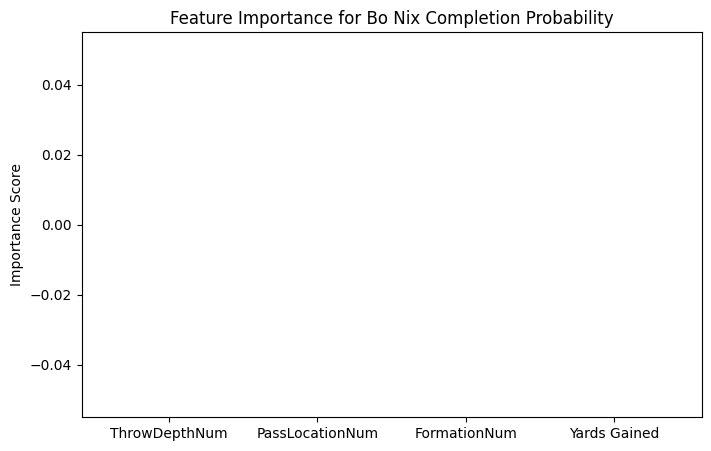

In [50]:
import matplotlib.pyplot as plt

importances = model.feature_importances_

plt.figure(figsize=(8,5))
plt.bar(X.columns, importances, color='skyblue')
plt.title("Feature Importance for Bo Nix Completion Probability")
plt.ylabel("Importance Score")
plt.show()